In [1]:
import json
import numexpr
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

tqdm.pandas()

In [2]:
from football_viz import plot_pitch_skc, plot_ff
from helper import transform_to_sck
from settings import *

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# Loading event data
event_data = pd.read_csv(f"{PROCESSED_FOLDER}{df_output_name}.csv")

# Create Id -  to match it Freeze Frames
event_data['id'] = event_data[['match_id', 'event_id']].apply(lambda x: pattern_match.format(x['match_id'], x['event_id']),axis=1)

In [4]:
# Loading freeze frames
with open(f"{PROCESSED_FOLDER}/{ff_output_name}.json", 'r') as f:
    ff_dict = json.load(f)

In [5]:
data = event_data.copy()
data['x_fix'] = data.progress_apply(lambda x: transform_to_sck(x['x'],x['y'])[0],axis=1)
data['y_fix'] = data.progress_apply(lambda x: transform_to_sck(x['x'],x['y'])[1],axis=1)
data['x2_fix'] = data.progress_apply(lambda x: transform_to_sck(x['x2'],x['y2'])[0],axis=1)
data['y2_fix'] = data.progress_apply(lambda x: transform_to_sck(x['x2'],x['y2'])[1],axis=1)

100%|██████████| 527378/527378 [00:05<00:00, 104248.45it/s]


In [6]:
match_ids = data['match_id'].unique().tolist()
len(match_ids)

380

## Finding Counter-Attacks for one match:

**Criteria:**
1. Sequence starts in defensive half
2. Ball moves at least 10 meters forward
3. Last event occurs within final third
4. No set pieces in sequence
5. Only take into account counter-attacks that began with defensive action 
6. Ball forward velocity > 4 m/s

**Succesful counter attack?**
- Pass in a sequence that enters the 18-yard box


### Sequence starts in defensive half

In [7]:
def get_chains_defensive_half(df):
    only_first_event_chain = df.drop_duplicates(subset='chain_id',keep='first').copy()
    # Because I already changed the coordinates to skillcorner coordinates x -> [-52.5, 52.5] the defensive third would be -52.5+(105/3)=-17.5
    defhalf_mask = (only_first_event_chain['x_fix']<-17.5)
    chains_starting_defhalf = only_first_event_chain.loc[defhalf_mask]
    # Save possession chains that meet criteria
    chains = chains_starting_defhalf.chain_id.unique().tolist()
    return chains

In [8]:
cdf = pd.DataFrame()
for mid in tqdm(match_ids):
    df = data[data['match_id']==mid].copy()
    chains_def_half = get_chains_defensive_half(df)
    cdf = pd.concat([cdf,df[df.chain_id.isin(chains_def_half)]],ignore_index=True)
len(cdf.match_id.unique().tolist())

100%|██████████| 380/380 [00:07<00:00, 52.50it/s] 


380

### Ball moves at least 10 meters forward

In [9]:
def get_chains_ball_10meters(df):
    first_last_event_chain = pd.concat([df.drop_duplicates(subset='chain_id',keep='first').copy(),df.drop_duplicates(subset='chain_id',keep='last').copy()])
    chains_ball_10meters = []
    for chain in first_last_event_chain.chain_id.unique().tolist():
        temp = first_last_event_chain[first_last_event_chain['chain_id']==chain]
        first = temp.iloc[0,:]
        last = temp.iloc[1,:]
        #Find distance between first event and last event of possession chain
        dist = ((first['x_fix']-last['x_fix'])**2+(first['y_fix']-last['y_fix'])**2)**0.5
        # Save possession chains that meet criteria
        if dist>10:
            chains_ball_10meters.append(chain)
    return chains_ball_10meters

In [10]:
cdf_b10 = pd.DataFrame()
for mid in tqdm(match_ids):
    df = cdf[cdf['match_id']==mid].copy()
    chains_ball_10meters = get_chains_ball_10meters(df)
    cdf_b10 = pd.concat([cdf_b10,df[df.chain_id.isin(chains_ball_10meters)]],ignore_index=True)
len(cdf_b10.match_id.unique().tolist())

100%|██████████| 380/380 [00:23<00:00, 16.19it/s]


380

### Last event within final third

In [11]:
def get_chains_final_third(df):
    only_last_event_chain = df.drop_duplicates(subset='chain_id',keep='last').copy()
    fin3rd_mask = (only_last_event_chain['x_fix']>17.5)
    chains_ending_fin3rd = only_last_event_chain.loc[fin3rd_mask]
    # Save possession chains that meet criteria
    chains = chains_ending_fin3rd.chain_id.unique().tolist()
    return chains

In [12]:
cdf_b10_f3 = pd.DataFrame()
for mid in tqdm(match_ids):
    df = cdf_b10[cdf_b10['match_id']==mid].copy()
    chains_fin3rd = get_chains_final_third(df)
    cdf_b10_f3 = pd.concat([cdf_b10_f3,df[df.chain_id.isin(chains_fin3rd)]],ignore_index=True)
len(cdf_b10_f3.match_id.unique().tolist())

100%|██████████| 380/380 [00:04<00:00, 93.18it/s] 


380

### No set-pieces or corners in sequence

In [13]:
cdf_b10_f3_nsp = pd.DataFrame()
for mid in tqdm(match_ids):
    df = cdf_b10_f3[cdf_b10_f3['match_id']==mid].copy()
    chains_w_setpieces = df.loc[df['description'].isin(['Throw-in Taken','Free Kick Taken','Corner Taken']),
                                'chain_id'].unique().tolist()
    # Save possession chains that meet criteria
    cdf_b10_f3_nsp = pd.concat([cdf_b10_f3_nsp,df[~df.chain_id.isin(chains_w_setpieces)]],ignore_index=True)
len(cdf_b10_f3_nsp.match_id.unique().tolist())

100%|██████████| 380/380 [00:02<00:00, 146.40it/s]


380

### Only take into account counter-attacks that began with a defensive action

In [14]:
def get_chains_def_actions(df):
    def_actions = ['Successful Pass', 'Unintentional Ball Touch','Successful Interception','Blocked Pass','Tackle and Possession',
                   'Failed Challenge','Aerial Duel Won', 'Shield Ball', 'Failed Pass','Successful Take-On']
    only_first_event_chain = df.drop_duplicates(subset='chain_id',keep='first').copy()
    chains_def_actions = only_first_event_chain.loc[only_first_event_chain['description'].isin(def_actions)]
    # Save possession chains that meet criteria
    chains = chains_def_actions.chain_id.unique().tolist()
    return chains

In [15]:
cdf_b10_f3_nsp_defac = pd.DataFrame()
for mid in tqdm(match_ids):
    df = cdf_b10_f3_nsp[cdf_b10_f3_nsp['match_id']==mid].copy()
    chains_defac = get_chains_def_actions(df)
    cdf_b10_f3_nsp_defac = pd.concat([cdf_b10_f3_nsp_defac,df[df.chain_id.isin(chains_defac)]],ignore_index=True)
len(cdf_b10_f3_nsp_defac.match_id.unique().tolist())

100%|██████████| 380/380 [00:02<00:00, 159.80it/s]


380

### Ball forward velocity 4 m/s

In [16]:
def get_chains_ball_4ms(df):
    df = df.copy()
    # Time in seconds when event occurred
    df['time2'] = df['min']*60+df['sec']
    # Time in seconds of previous event
    df['time'] = df['time2'].shift()
    # Only take into account passes
    df['prevEvent'] = df['description'].shift()
    only_passes_mask = (df['description']=='Successful Pass') & (df['prevEvent']=='Successful Pass')
    df = df.loc[only_passes_mask]
    # Distance covered
    df['distance'] = (((df['x_fix']-df['x2_fix'])**2+(df['y_fix']-df['y2_fix'])**2)**0.5)
    # Speed
    df['speed'] = df['distance']/(df['time2']-df['time'])

    df_gby = df.groupby('chain_id')['speed'].mean().reset_index().rename(columns={'speed':'avg_speed'})
    chains = df_gby.loc[df_gby['avg_speed']>=4,'chain_id'].unique().tolist()
    return chains

In [17]:
cdf_b10_f3_nsp_defac_b4ms = pd.DataFrame()
for mid in tqdm(match_ids):
    df = cdf_b10_f3_nsp_defac[cdf_b10_f3_nsp_defac['match_id']==mid].copy()
    chains_ball_4ms = get_chains_ball_4ms(df)
    cdf_b10_f3_nsp_defac_b4ms = pd.concat([cdf_b10_f3_nsp_defac_b4ms,df[df['chain_id'].isin(chains_ball_4ms)]],ignore_index=True)
len(cdf_b10_f3_nsp_defac_b4ms.match_id.unique().tolist())

100%|██████████| 380/380 [00:04<00:00, 94.04it/s] 


380

### Successful counter attacks

In [18]:
def in_box(x,y):
    box_coords_x = [36,52.5]
    box_coords_y = [-20.15,20.15]
    if ((x>=box_coords_x[0]) and (x<=box_coords_x[1])) and (((y>=box_coords_y[0]) and (y<=box_coords_y[1]))):
        return 1
    else:
        return 0
def get_successful_chains(df):
    df = df[df['type'] == 1].copy()
    df['success?'] = df.apply(lambda x: 1 if x['shot']==1 else in_box(x['x2'],x['y2']),axis=1)
    chains = df.loc[df['success?']==1,'chain_id'].unique().tolist()
    return chains

In [19]:
cdf_b10_f3_nsp_defac_b4ms_succ = pd.DataFrame()
for mid in tqdm(match_ids):
    df = cdf_b10_f3_nsp_defac_b4ms[cdf_b10_f3_nsp_defac_b4ms['match_id']==mid].copy()
    succesful_counterattacks = get_successful_chains(df)
    df['successful'] = df.apply(lambda x: 1 if x['chain_id'] in succesful_counterattacks else 0, axis=1)
    cdf_b10_f3_nsp_defac_b4ms_succ = pd.concat([cdf_b10_f3_nsp_defac_b4ms_succ,df],ignore_index=True)
len(cdf_b10_f3_nsp_defac_b4ms_succ.match_id.unique().tolist())

100%|██████████| 380/380 [00:03<00:00, 126.41it/s]


380

### Find xT from passes

In [20]:
xT = pd.read_csv('Data/EPV_grid.csv', header=None).values

In [21]:
df_all = cdf_b10_f3_nsp_defac_b4ms_succ.copy()

In [22]:
from scipy.stats import binned_statistic_2d

df_all = df_all.loc[(df_all['type']==1) & (df_all['description']=='Successful Pass')]

df_all["start_sector"] = df_all.progress_apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x_fix), np.ravel(row.y_fix), 
                                                                                                    values = "None", statistic="count",
                                                                                                    bins=(49, 31), range=[[-52.5, 52.5], [-34, 34]],
                                                                                                    expand_binnumbers=True)[3]]), axis = 1)
    
df_all["end_sector"] = df_all.progress_apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x2), np.ravel(row.y2), 
                                                                                                  values = "None", statistic="count",
                                                                                                  bins=(49, 31), range=[[-52.5, 52.5], [-34, 34]],
                                                                                                  expand_binnumbers=True)[3]]), axis = 1)

df_all['xT_added'] = df_all.progress_apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1]
                                                     - xT[row.start_sector[1] - 1][row.start_sector[0] - 1], axis = 1)

100%|██████████| 27153/27153 [00:00<00:00, 29273.70it/s]


In [23]:
len(df_all.match_id.unique().tolist())

380

### Merging with tracking data

In [24]:
pass_kv = {x[0]: {'x1':x[1], 'x2':x[2],'y1':x[3],'y2':x[4]} for x in df_all[['id', 'x', 'x2', 'y', 'y2']].values}

In [25]:
def calc_mean(data):
    if len(data) == 0:
        return -1
    avg = sum(data)/len(data)
    return round(avg,4)

# speed is sqrt(vx^2 + vy^2)
def count_players_with_sprint(data, min_speed = 6.5):
    speeds = [np.sqrt(x['vx'] ** 2 + x['vy'] ** 2) for x in data]
    return len([x for x in speeds if x >= min_speed])

In [26]:
def merge_tracking_with_event_data(df, ff_dict):
    df = df.copy()
    # pass_kv has dictionary
    # passes_df includes all passes
    # Read Processed Freeze Frames
    tracking_data = dict()
    try:
        for key, value in tqdm(ff_dict.items()):
            if key not in pass_kv.keys(): # If event data not exists
                continue
        
            defenders = list(filter(lambda x: x['team_status'] == 'defense' and x['player_position'] != 'GK', value))
            attackers = list(filter(lambda x: x['team_status'] == 'offense' and x['player_position'] != 'GK', value))

            player_with_ball = list(filter(lambda x: x['player_with_event'], value))
            ball_ = list(filter(lambda x: x['team'] == 'ball', value))
            
            # Get Event Location
            start_x = -1
            start_y = -1
            if len(player_with_ball) != 0:
                player_with_ball = player_with_ball[0]
                start_x = player_with_ball['x_opta']
                start_y = player_with_ball['y_opta']
            elif len(ball_) != 0 and ball_[0]['x_opta'] != -1:
                player_with_ball = ball_[0]
                start_x = player_with_ball['x_opta']
                start_y = player_with_ball['y_opta']
            else:
                continue
            
            # Calculate Packing
            tracking_data[key] = {
                'defense_avg_speed': calc_mean([np.sqrt(x['vx'] ** 2 + x['vy'] ** 2) for x in defenders]),
                'offense_avg_speed': calc_mean([np.sqrt(x['vx'] ** 2 + x['vy'] ** 2) for x in attackers]),
                'num_players_sprints_offence': count_players_with_sprint(attackers),
                'num_players_sprints_defence': count_players_with_sprint(defenders),
            }
            
    except Exception as err:
            print(err, key)
    
    df_tracking_data = pd.DataFrame(tracking_data).T.reset_index()

    # merge data
    df_final = df.merge(df_tracking_data, left_on='id', right_on='index', how='inner')

    #df_final.to_csv(f"{PROCESSED_FOLDER}/{df_output_name_pass}.csv",index=None)
    #df_tracking_data.sample(5)
    return df_final

In [27]:
counterattacks_final = merge_tracking_with_event_data(df_all,ff_dict)

100%|██████████| 524078/524078 [00:09<00:00, 52848.35it/s]


In [28]:
counterattacks_final = counterattacks_final[counterattacks_final['successful']==1]

### Team data

In [29]:
df_players_all = pd.read_csv('Data/PL_2020-21_Player_info.csv')

In [30]:
player_team = pd.concat([df_players_all[['PlayerName','homeTeamName','homeTeamId','PlayerId','Position','MinutesPlayed']].copy().rename(columns={'homeTeamName':'teamName','homeTeamId':'teamId'}),
                         df_players_all[['PlayerName','awayTeamName','awayTeamId','PlayerId','Position','MinutesPlayed']].copy().rename(columns={'awayTeamName':'teamName','awayTeamId':'teamId'}),],ignore_index=True)

df_players = pd.DataFrame()
for player in tqdm(player_team['PlayerName'].unique().tolist()):
    playerid = player_team.loc[player_team['PlayerName']==player,'PlayerId'].mode()[0]
    pos = player_team.loc[player_team['PlayerName']==player,'Position'].mode()[0]
    temp = player_team.loc[player_team['PlayerName']==player,['teamName','teamId']].mode()
    temp['playerName'] = player
    temp['playerId'] = playerid
    temp['position'] = pos
    temp['minutesPlayed'] = player_team.loc[player_team['PlayerName']==player,'MinutesPlayed'].sum()
    df_players = pd.concat([df_players,temp[['playerName','playerId','position','minutesPlayed','teamName','teamId']]],ignore_index=True)
df_players = df_players[df_players['minutesPlayed']>=500]

100%|██████████| 516/516 [00:05<00:00, 87.03it/s]


In [31]:
df_players.sample(5)

,playerName,playerId,position,minutesPlayed,teamName,teamId
392,Gareth Bale,36903,RW,1932,Tottenham Hotspur,6
157,Eric Dier,93264,LCB,5258,Tottenham Hotspur,6
363,Cengiz Ünder,228798,RW,626,Leicester City,13
312,Jairo Riedewald,173954,LM,3566,Crystal Palace,31
311,Christian Benteke,54861,CF,3824,Crystal Palace,31


In [32]:
df_teams = df_players_all[['homeTeamName','homeTeamId']].copy().drop_duplicates(keep='last').reset_index(drop=True).rename(columns={'homeTeamName':'team','homeTeamId':'team_id'})
df_teams.sample(5)

,team,team_id
0,Chelsea,8
15,Liverpool,14
1,Brighton and Hove Albion,36
5,Manchester United,1
13,Leeds United,2


## Finding metrics

1. Goals from counterattacks
2. Least amount of passes in counterattack
3. Successful counterattacks
4. xT from counterattacks
5. Speed while attacking in counterattacks (fastest teams)
6. Most involved players per team in pass sequence during counterattacks

### Goals from counterattacks

In [33]:
goal_ca = counterattacks_final.drop_duplicates(subset=['match_id','team_id','chain_id'],keep='last').groupby('team_id')['goal'].sum()
goal_ca = goal_ca.reset_index().rename(columns={'goal':'goal_counts'})

### Least amount of passes in counterattack

In [34]:
least_passes = counterattacks_final.groupby(['match_id','team_id','chain_id'])['description'].value_counts().reset_index(name='counts').groupby('team_id')['counts'].mean().reset_index(name='avg_num_passes')

### Successful counterattacks

In [35]:
success_ca = counterattacks_final.drop_duplicates(subset=['match_id','team_id','chain_id'],keep='last').groupby('team_id')['successful'].sum()
success_ca = success_ca.reset_index().rename(columns={'succesful':'successful_counts'})

### xT from counterattacks

In [36]:
xT_ca = counterattacks_final.groupby(['match_id','team_id','chain_id'])['xT_added'].sum().reset_index(name='total_xT').groupby('team_id')['total_xT'].mean().reset_index(name='avg_xT_counterattack')

### Average Speed while attacking

In [37]:
speed_ca = counterattacks_final.groupby(['match_id','team_id','chain_id'])['offense_avg_speed'].mean().reset_index(name='avg_speed_chain').groupby('team_id')['avg_speed_chain'].mean().reset_index(name='avg_speed_counterattack')

### Most involved players per team in pass sequence

In [38]:
players_involved = counterattacks_final.groupby('player_id')['description'].value_counts()
players_involved = players_involved.reset_index(name='involvements')

In [39]:
summary_teams = df_teams.copy()
summary_teams = summary_teams.merge(goal_ca, how='inner', on='team_id').merge(least_passes, how='inner', on='team_id').merge(success_ca, how='inner', on='team_id').merge(xT_ca, how='inner', on='team_id').merge(speed_ca, how='inner', on='team_id')
summary_teams

,team,team_id,goal_counts,avg_num_passes,successful,avg_xT_counterattack,avg_speed_counterattack
0,Chelsea,8,10,9.550000,100,0.401919,2.654920
1,Brighton and Hove Albion,36,2,8.342466,73,0.370496,2.641786
2,Burnley,90,4,4.611111,54,0.167531,2.750030
3,Crystal Palace,31,2,5.456522,46,0.190598,2.448511
4,Everton,11,1,7.942029,69,0.363757,2.710476
5,Manchester United,1,11,7.272727,110,0.360610,2.726995
6,Newcastle United,4,6,4.909091,66,0.206170,2.860043
7,Southampton,20,6,8.174603,63,0.333613,2.568552
8,Tottenham Hotspur,6,2,7.000000,73,0.312277,2.747230
9,West Bromwich Albion,35,2,4.280702,57,0.191582,2.686195


In [40]:
def percentile(df):
    df = df.copy()
    df = df.set_index(['team','team_id'])
    for col in df.columns:
        new_col = col+'_pct'
        if (df[col].dtype.name != 'object'):
            if col not in ['avg_num_passes']:
                df[new_col] = df[col].rank(pct=True,)
            else:
                df[new_col] = df[col].rank(pct=True, ascending=False)
    df = df.reset_index()
    return df

summary_teams_pct = percentile(summary_teams)

In [41]:
summary_teams_pct[['team','team_id','goal_counts','goal_counts_pct']].sort_values(by='goal_counts_pct',ascending=False)

,team,team_id,goal_counts,goal_counts_pct
5,Manchester United,1,11,1.000
0,Chelsea,8,10,0.950
10,Arsenal,3,9,0.900
13,Leeds United,2,8,0.850
6,Newcastle United,4,6,0.750
7,Southampton,20,6,0.750
15,Liverpool,14,6,0.750
16,Manchester City,43,5,0.625
14,Leicester City,13,5,0.625
19,Wolverhampton Wanderers,39,4,0.500


In [42]:
summary_teams_pct[['team','team_id','avg_num_passes','avg_num_passes_pct']].sort_values(by='avg_num_passes_pct',ascending=False)

,team,team_id,avg_num_passes,avg_num_passes_pct
9,West Bromwich Albion,35,4.280702,1.00
2,Burnley,90,4.611111,0.95
6,Newcastle United,4,4.909091,0.90
3,Crystal Palace,31,5.456522,0.85
18,West Ham United,21,5.746667,0.80
11,Aston Villa,7,5.959459,0.75
13,Leeds United,2,6.787037,0.70
8,Tottenham Hotspur,6,7.000000,0.65
17,Sheffield United,49,7.060606,0.60
5,Manchester United,1,7.272727,0.55


In [43]:
summary_teams_pct[['team','team_id','successful','successful_pct']].sort_values(by='successful_pct',ascending=False)

,team,team_id,successful,successful_pct
15,Liverpool,14,111,1.000
5,Manchester United,1,110,0.950
13,Leeds United,2,108,0.900
19,Wolverhampton Wanderers,39,103,0.850
0,Chelsea,8,100,0.800
10,Arsenal,3,95,0.750
14,Leicester City,13,94,0.700
16,Manchester City,43,93,0.650
18,West Ham United,21,75,0.600
11,Aston Villa,7,74,0.550


In [44]:
summary_teams_pct[['team','team_id','avg_xT_counterattack','avg_xT_counterattack_pct']].sort_values(by='avg_xT_counterattack_pct',ascending=False)

,team,team_id,avg_xT_counterattack,avg_xT_counterattack_pct
16,Manchester City,43,0.438127,1.00
19,Wolverhampton Wanderers,39,0.417983,0.95
15,Liverpool,14,0.416600,0.90
0,Chelsea,8,0.401919,0.85
10,Arsenal,3,0.387342,0.80
12,Fulham,54,0.372637,0.75
1,Brighton and Hove Albion,36,0.370496,0.70
4,Everton,11,0.363757,0.65
5,Manchester United,1,0.360610,0.60
17,Sheffield United,49,0.338480,0.55


In [45]:
summary_teams_pct[['team','team_id','avg_speed_counterattack','avg_speed_counterattack_pct']].sort_values(by='avg_speed_counterattack_pct',ascending=False)

,team,team_id,avg_speed_counterattack,avg_speed_counterattack_pct
13,Leeds United,2,3.085191,1.00
11,Aston Villa,7,2.938585,0.95
6,Newcastle United,4,2.860043,0.90
18,West Ham United,21,2.820486,0.85
2,Burnley,90,2.750030,0.80
8,Tottenham Hotspur,6,2.747230,0.75
5,Manchester United,1,2.726995,0.70
4,Everton,11,2.710476,0.65
12,Fulham,54,2.689480,0.60
10,Arsenal,3,2.687730,0.55


In [46]:
summary_teams_pct.columns

Index(['team', 'team_id', 'goal_counts', 'avg_num_passes', 'successful', 'avg_xT_counterattack', 'avg_speed_counterattack', 'goal_counts_pct', 'avg_num_passes_pct', 'successful_pct', 'avg_xT_counterattack_pct', 'avg_speed_counterattack_pct'], dtype='object')

In [47]:
from mplsoccer import PyPizza, FontManager

In [48]:
big_six = ['Manchester City','Manchester United','Chelsea','Tottenham Hotspur','Liverpool','Arsenal']
interesting = ['Aston Villa','Newcastle United','Leeds United','Wolverhampton Wanderers']

In [49]:
name_changes = {'goal_counts':'Goals',
                'avg_num_passes':'Avg. Number of Passes',
                'successful':'Successful counter-attacks',
                'avg_xT_counterattack':'Avg. xT in counter-attack',
                'avg_speed_counterattack':'Avg. speed in counter-attack'}

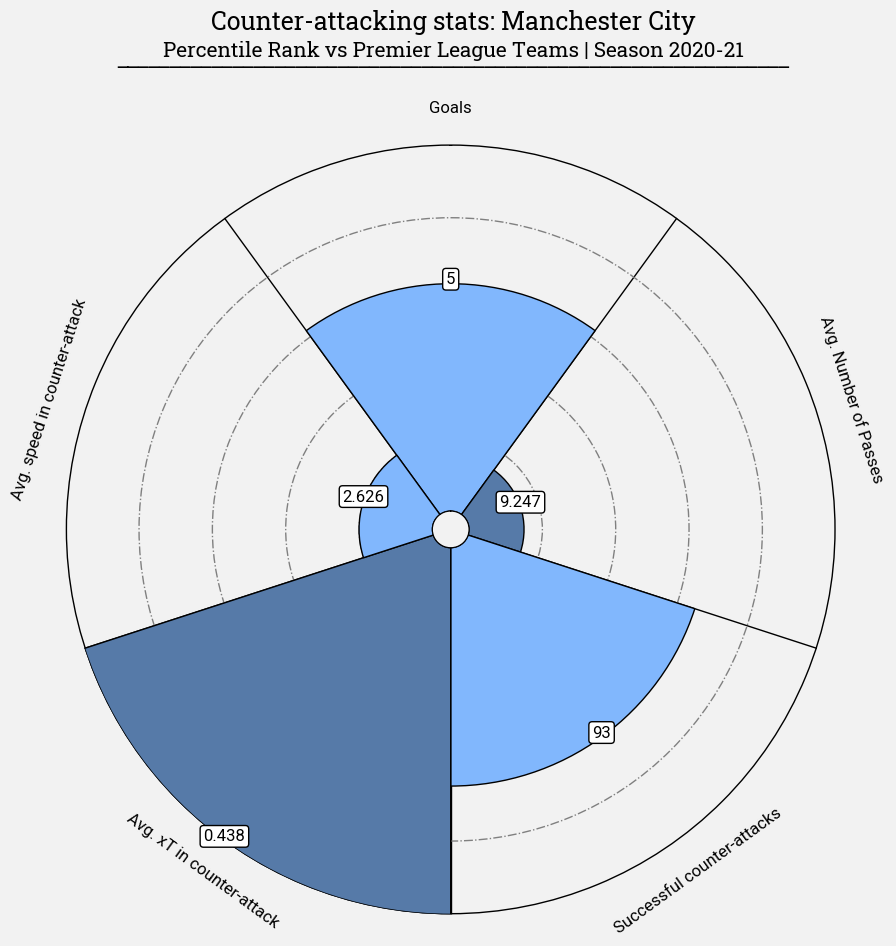

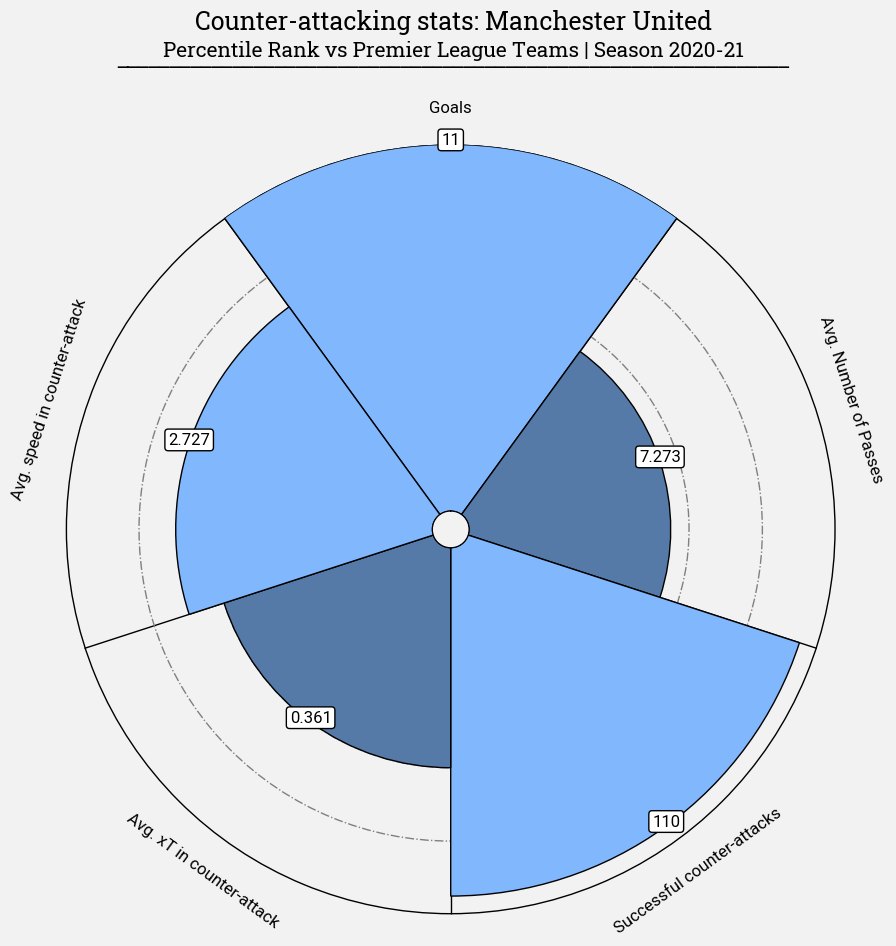

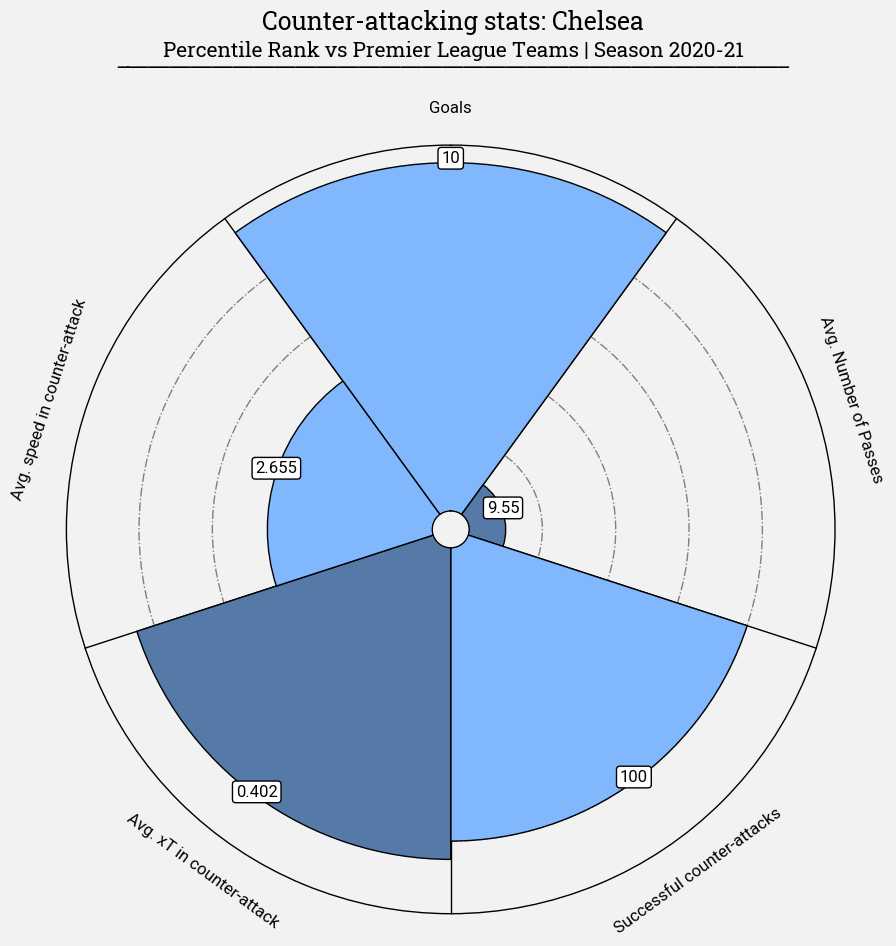

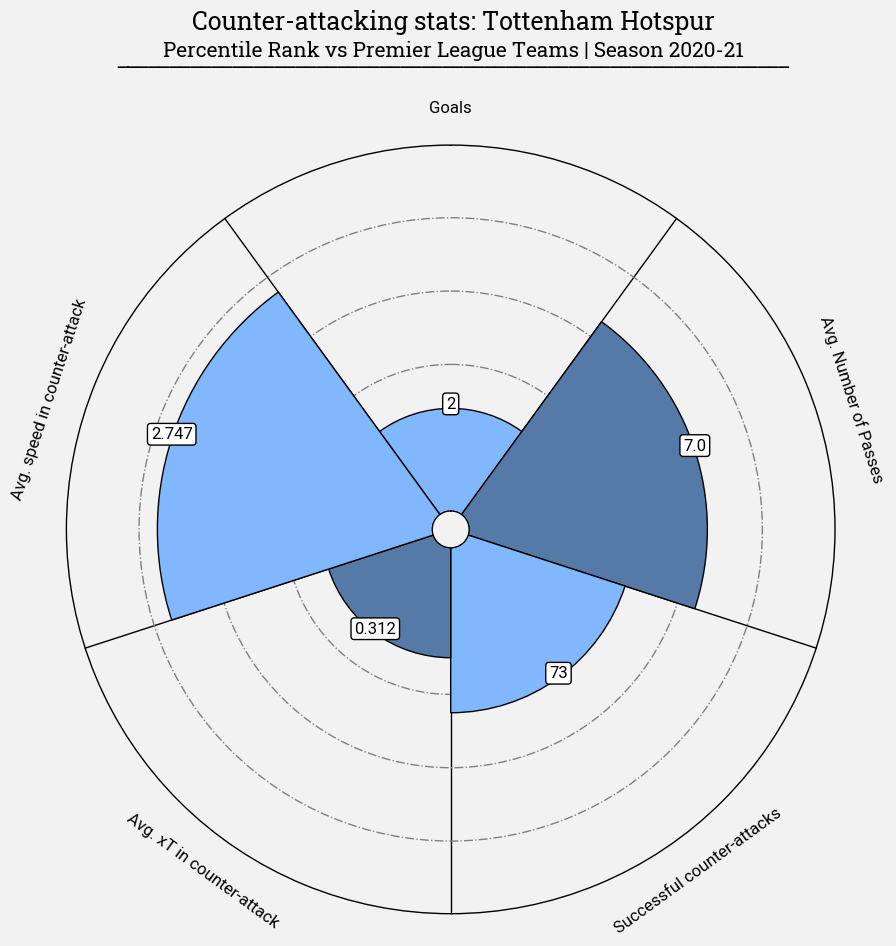

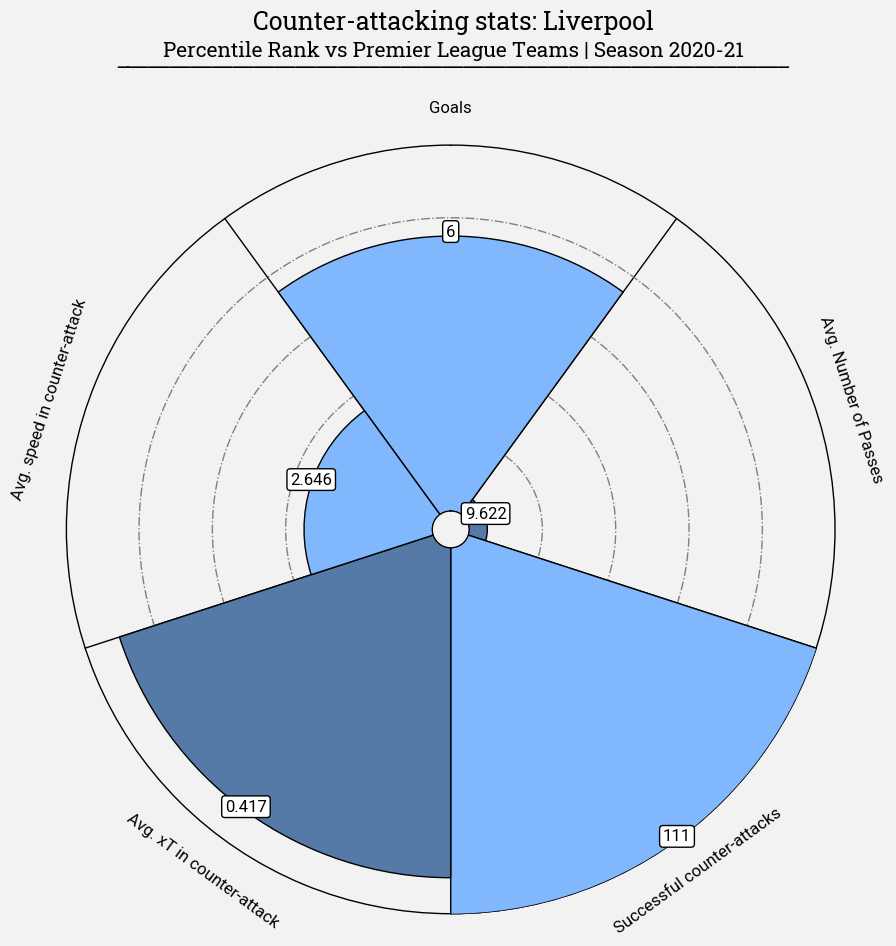

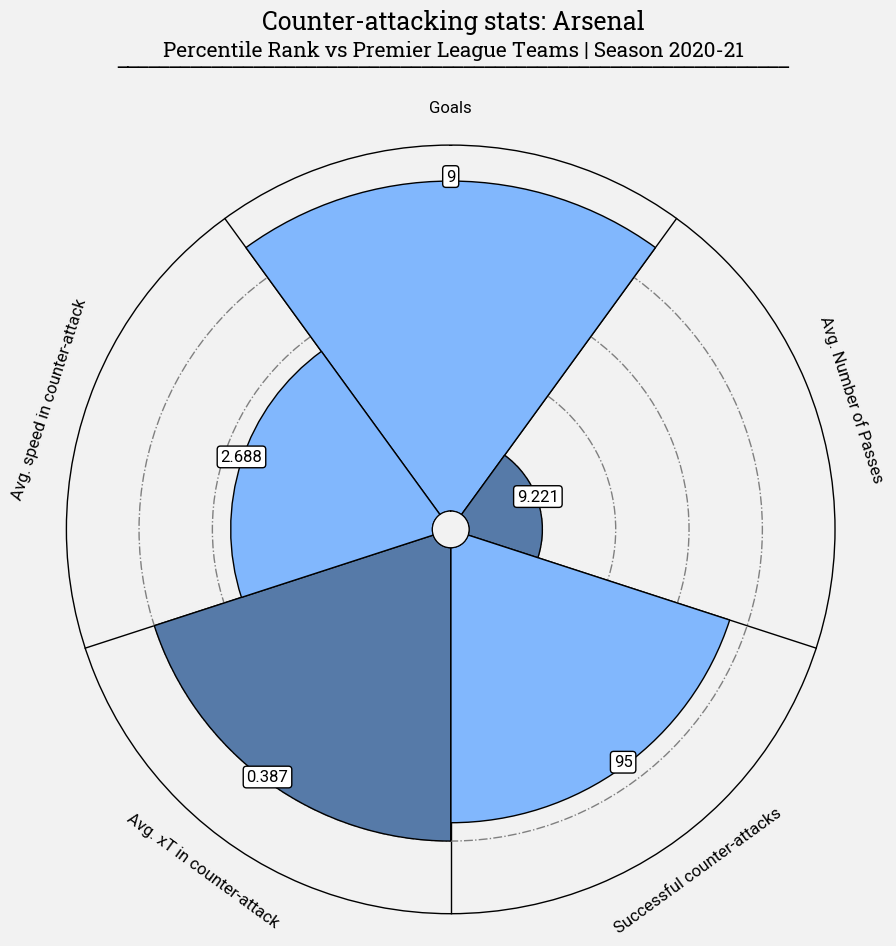

In [50]:
for team in big_six:
    team_perc = summary_teams_pct.loc[summary_teams_pct['team']==team,['goal_counts_pct','avg_num_passes_pct','successful_pct','avg_xT_counterattack_pct','avg_speed_counterattack_pct']]
    team_raw = summary_teams_pct.loc[summary_teams_pct['team']==team,['goal_counts','avg_num_passes','successful','avg_xT_counterattack','avg_speed_counterattack']]
    team_raw = team_raw.rename(columns=name_changes)

    names = ['Goals','Avg. Number of Passes','Successful counter-attacks','Avg. xT in counter-attack','Avg. speed in counter-attack']
    names_pct = ['goal_counts_pct','avg_num_passes_pct','successful_pct','avg_xT_counterattack_pct','avg_speed_counterattack_pct']
    values = [team_raw[column].iloc[0] for column in names]
    percentiles = [np.round((team_perc[column].iloc[0])*100,0) for column in names_pct]
    #list of names on plots
    slice_colors = ["#81b7fd","#567aa8","#81b7fd","#567aa8","#81b7fd"]
    text_colors = ["black"] * len(names)
    font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                            "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
    font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                            "RobotoSlab%5Bwght%5D.ttf?raw=true"))
    #PIZZA PLOT
    baker = PyPizza(
        params=names,
        min_range = None,
        max_range = None,               # list of parameters
        straight_line_color="#000000",  # color for straight lines
        straight_line_lw=1,             # linewidth for straight lines
        last_circle_lw=2,               # linewidth of last circle
        other_circle_lw=1,              # linewidth for other circles
        other_circle_ls="-."            # linestyle for other circles
    )
    #making pizza for our data
    fig, ax = baker.make_pizza(
        percentiles,              # list of values
        figsize=(10, 10),      # adjust figsize according to your need
        param_location=110,
        slice_colors = slice_colors,
        value_colors = text_colors,
        value_bck_colors = ["white"]*len(names), # where the parameters will be added
        kwargs_slices=dict(
            #facecolor="cornflowerblue", 
            edgecolor="#000000",
            zorder=2, linewidth=1
        ),                   # values to be used when plotting slices
        kwargs_params=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, va="center"
        ),                   # values to be used when adding parameter
        kwargs_values=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", #facecolor="cornflowerblue",
                boxstyle="round,pad=0.2", lw=1
            )
        )                    # values to be used when adding parameter-values
    )

    #putting text
    texts = baker.get_value_texts()
    for i, text in enumerate(texts):
        text.set_text(str(np.round(values[i],3)))

    # add title
    fig.text(
        x=0.515,
        y= 0.995,
        s=f"Counter-attacking stats: {team}",
        size=18,
        ha="center",
        color="#000000",
        fontproperties=font_bold.prop,
    )

    # add subtitle
    fig.text(
        x=0.515,
        y=0.968,
        s="Percentile Rank vs Premier League Teams | Season 2020-21",
        size=15,
        ha="center",
        color="#000000",
        fontproperties=font_bold.prop
    )

    fig.text(
        x=0.515,
        y=0.962,
        s="________________________________________________________________",
        size=15,
        ha="center",
        color="#000000",
    )

    plt.show()

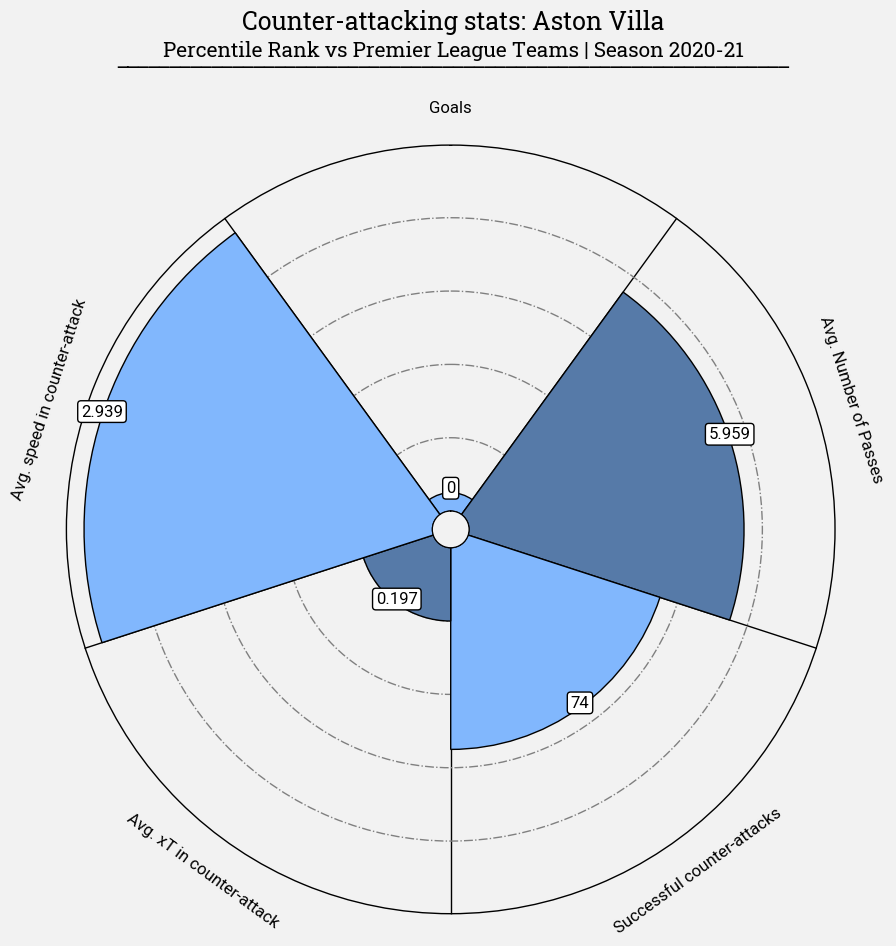

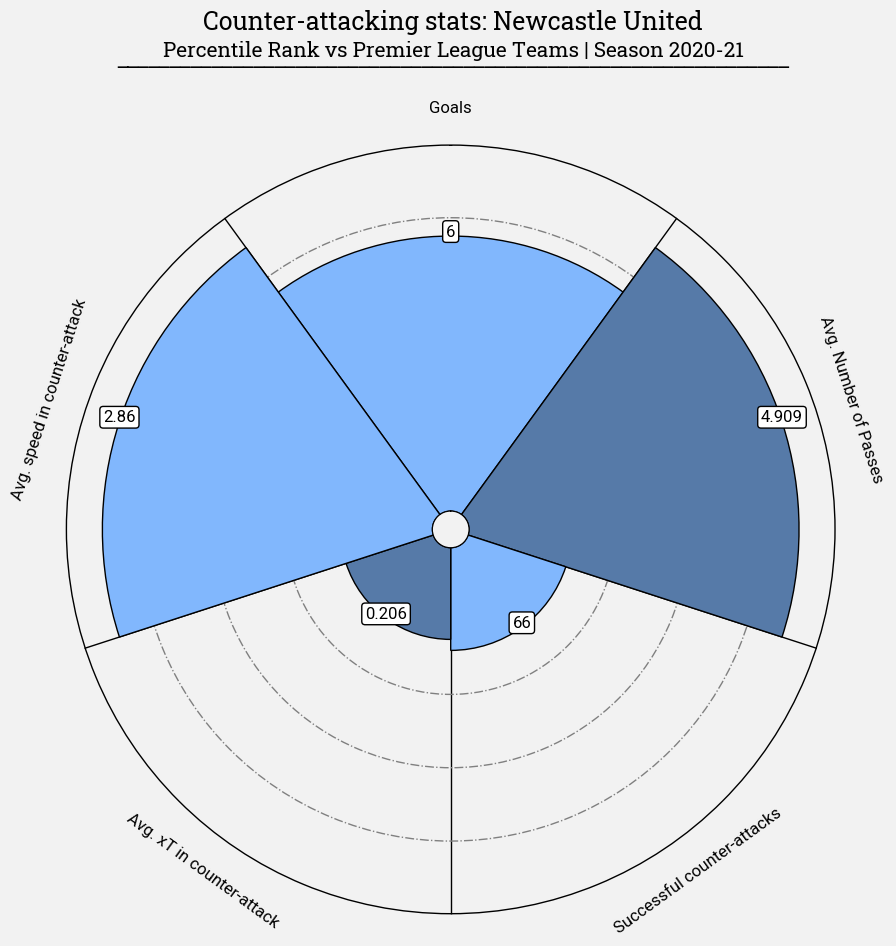

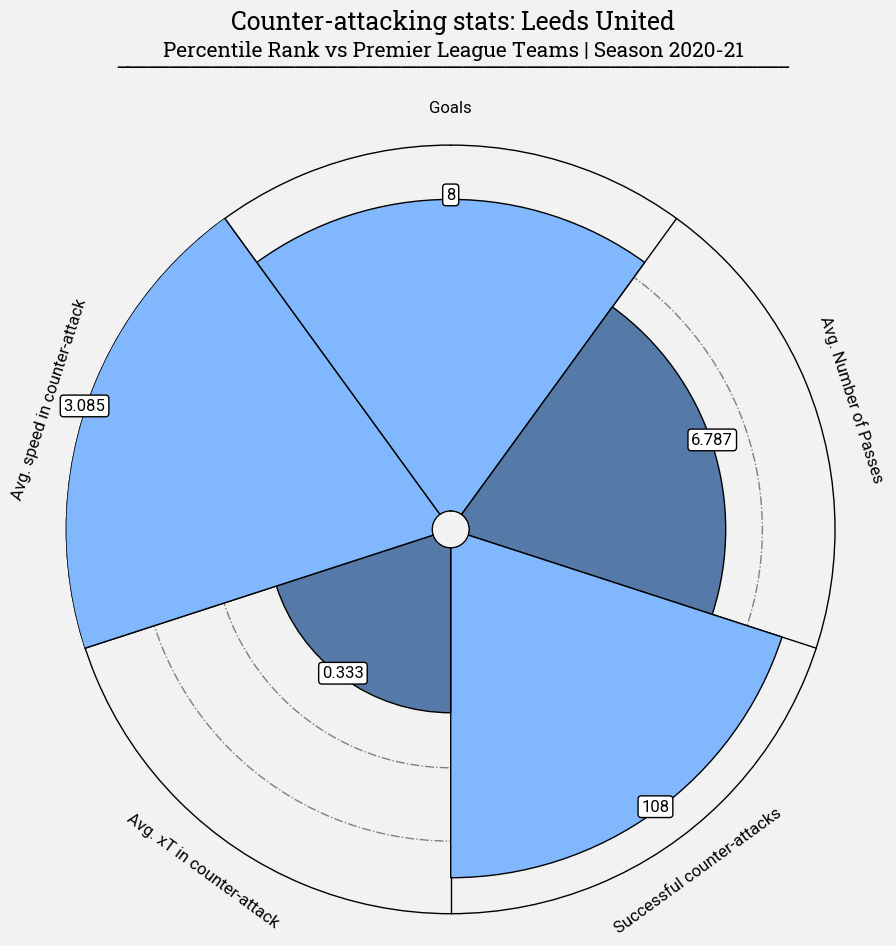

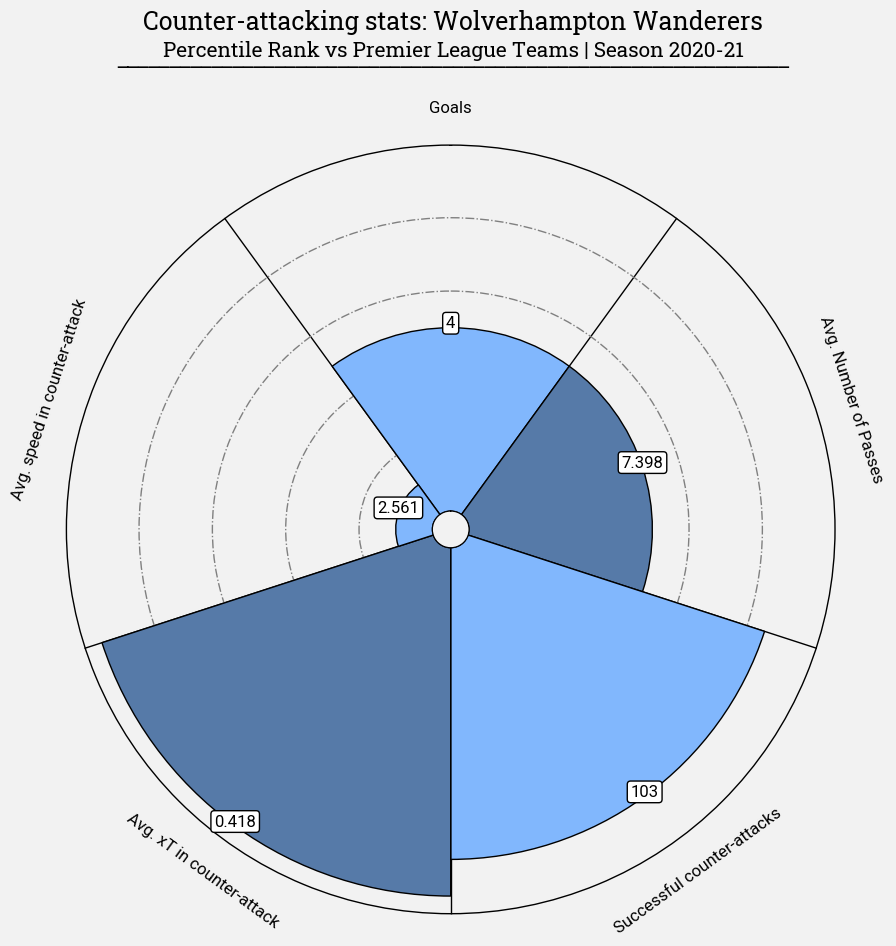

In [51]:
for team in interesting:
    team_perc = summary_teams_pct.loc[summary_teams_pct['team']==team,['goal_counts_pct','avg_num_passes_pct','successful_pct','avg_xT_counterattack_pct','avg_speed_counterattack_pct']]
    team_raw = summary_teams_pct.loc[summary_teams_pct['team']==team,['goal_counts','avg_num_passes','successful','avg_xT_counterattack','avg_speed_counterattack']]
    team_raw = team_raw.rename(columns=name_changes)

    names = ['Goals','Avg. Number of Passes','Successful counter-attacks','Avg. xT in counter-attack','Avg. speed in counter-attack']
    names_pct = ['goal_counts_pct','avg_num_passes_pct','successful_pct','avg_xT_counterattack_pct','avg_speed_counterattack_pct']
    values = [team_raw[column].iloc[0] for column in names]
    percentiles = [np.round((team_perc[column].iloc[0])*100,0) for column in names_pct]
    #list of names on plots
    slice_colors = ["#81b7fd","#567aa8","#81b7fd","#567aa8","#81b7fd"]
    text_colors = ["black"] * len(names)
    font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                            "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
    font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                            "RobotoSlab%5Bwght%5D.ttf?raw=true"))
    #PIZZA PLOT
    baker = PyPizza(
        params=names,
        min_range = None,
        max_range = None,               # list of parameters
        straight_line_color="#000000",  # color for straight lines
        straight_line_lw=1,             # linewidth for straight lines
        last_circle_lw=2,               # linewidth of last circle
        other_circle_lw=1,              # linewidth for other circles
        other_circle_ls="-."            # linestyle for other circles
    )
    #making pizza for our data
    fig, ax = baker.make_pizza(
        percentiles,              # list of values
        figsize=(10, 10),      # adjust figsize according to your need
        param_location=110,
        slice_colors = slice_colors,
        value_colors = text_colors,
        value_bck_colors = ["white"]*len(names), # where the parameters will be added
        kwargs_slices=dict(
            #facecolor="cornflowerblue", 
            edgecolor="#000000",
            zorder=2, linewidth=1
        ),                   # values to be used when plotting slices
        kwargs_params=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, va="center"
        ),                   # values to be used when adding parameter
        kwargs_values=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", #facecolor="cornflowerblue",
                boxstyle="round,pad=0.2", lw=1
            )
        )                    # values to be used when adding parameter-values
    )

    #putting text
    texts = baker.get_value_texts()
    for i, text in enumerate(texts):
        text.set_text(str(np.round(values[i],3)))

    # add title
    fig.text(
        x=0.515,
        y= 0.995,
        s=f"Counter-attacking stats: {team}",
        size=18,
        ha="center",
        color="#000000",
        fontproperties=font_bold.prop,
    )

    # add subtitle
    fig.text(
        x=0.515,
        y=0.968,
        s="Percentile Rank vs Premier League Teams | Season 2020-21",
        size=15,
        ha="center",
        color="#000000",
        fontproperties=font_bold.prop
    )

    fig.text(
        x=0.515,
        y=0.962,
        s="________________________________________________________________",
        size=15,
        ha="center",
        color="#000000",
    )

    plt.show()

In [83]:
import seaborn as sns
from adjustText import adjust_text

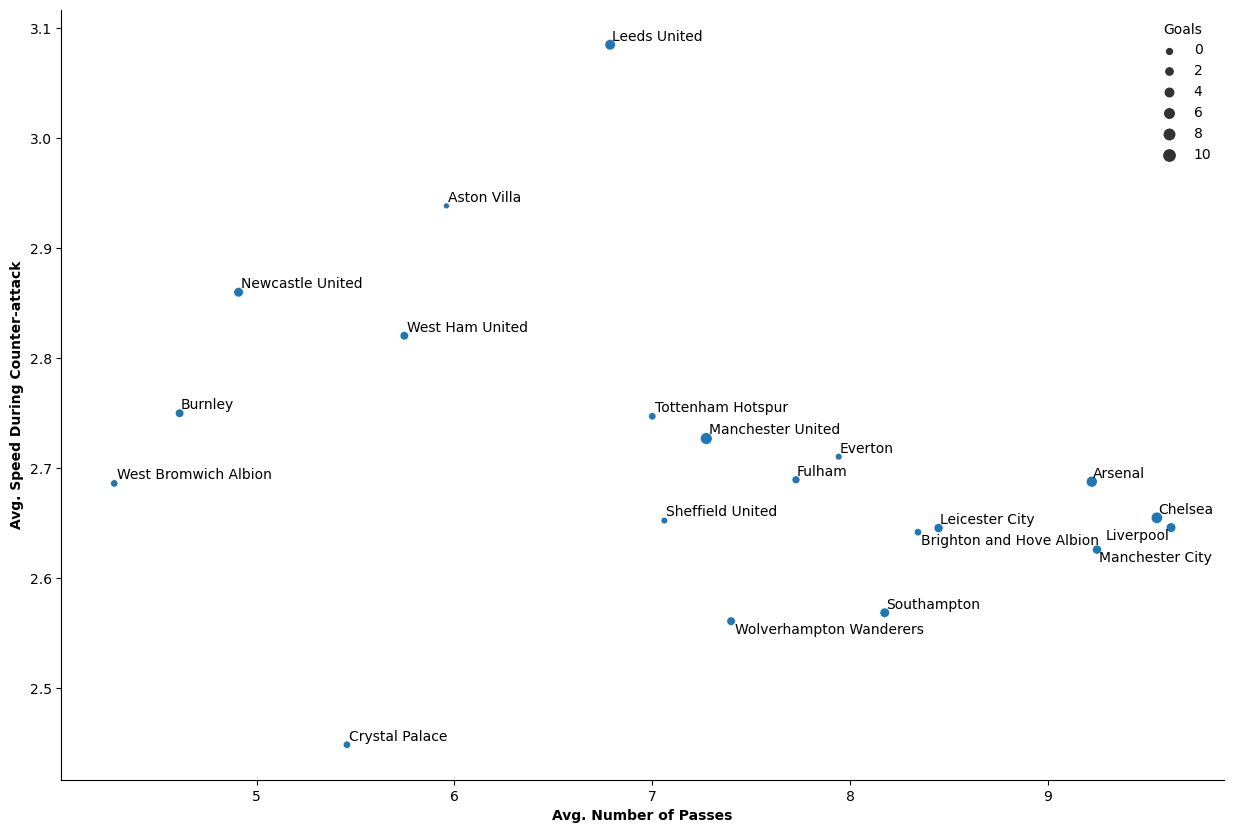

In [89]:
speed_v_numpass = summary_teams_pct[['team','avg_num_passes','avg_speed_counterattack','goal_counts']]

fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(data=speed_v_numpass,x='avg_num_passes',y='avg_speed_counterattack',size='goal_counts',ax=ax)
ax.legend(title="Goals",bbox_to_anchor=(1,1),frameon=False)
ax.set_xlabel('Avg. Number of Passes', fontweight='bold')
ax.set_ylabel('Avg. Speed During Counter-attack', fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
texts = []
for i in range(len(speed_v_numpass)):
    texts.append(plt.text(speed_v_numpass['avg_num_passes'][i],speed_v_numpass['avg_speed_counterattack'][i],str(speed_v_numpass['team'][i]),
                 size = 10, color = 'black'))#, bbox=dict(facecolor='white',alpha=0.7)))
adjust_text(texts)
plt.show()

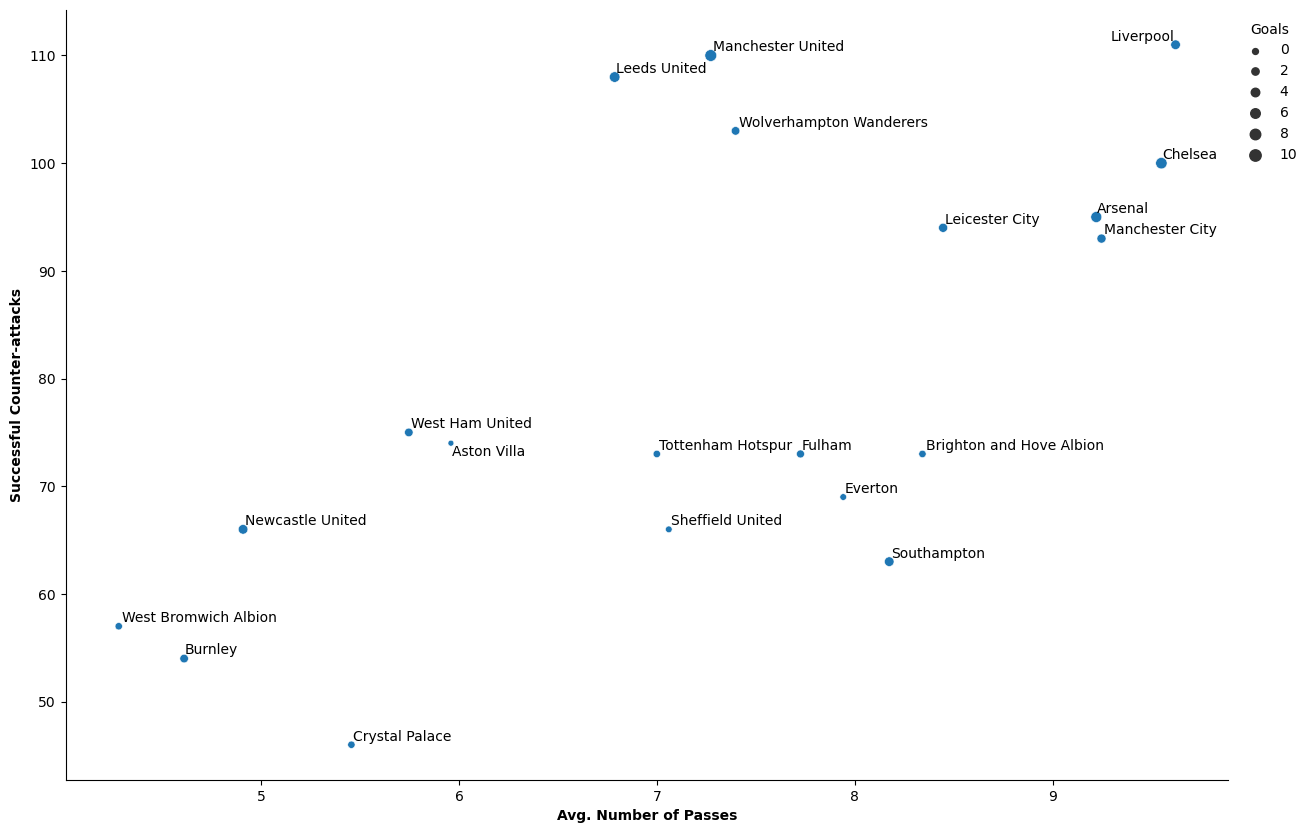

In [95]:
speed_v_succ = summary_teams_pct[['team','avg_num_passes','successful','goal_counts']]

fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(data=speed_v_succ,x='avg_num_passes',y='successful',size='goal_counts',ax=ax)
ax.legend(title="Goals",bbox_to_anchor=(1,1),frameon=False)
ax.set_xlabel('Avg. Number of Passes', fontweight='bold')
ax.set_ylabel('Successful Counter-attacks', fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
texts = []
for i in range(len(speed_v_numpass)):
    texts.append(plt.text(speed_v_succ['avg_num_passes'][i],speed_v_succ['successful'][i],str(speed_v_succ['team'][i]),
                 size = 10, color = 'black'))#, bbox=dict(facecolor='white',alpha=0.7)))
adjust_text(texts)
plt.show()

In [ ]:
speed_v_succ = summary_teams_pct[['team','successful','avg_speed_counterattack','goal_counts']]

fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(data=speed_v_succ,x='avg_speed_counterattack',y='successful',size='goal_counts',ax=ax)
ax.legend(title="Goals",bbox_to_anchor=(1,1),frameon=False)
ax.set_xlabel('Avg. Speed During Counter-attack', fontweight='bold')
ax.set_ylabel('Successful Counter-attacks', fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
texts = []
for i in range(len(speed_v_succ)):
    texts.append(plt.text(speed_v_succ['avg_speed_counterattack'][i],speed_v_succ['successful'][i],str(speed_v_succ['team'][i]),
                 size = 10, color = 'black'))#, bbox=dict(facecolor='white',alpha=0.7)))
adjust_text(texts)
plt.show()

In [52]:
summary_teams_pct

,team,team_id,goal_counts,avg_num_passes,successful,avg_xT_counterattack,avg_speed_counterattack,goal_counts_pct,avg_num_passes_pct,successful_pct,avg_xT_counterattack_pct,avg_speed_counterattack_pct
0,Chelsea,8,10,9.550000,100,0.401919,2.654920,0.950,0.10,0.800,0.85,0.45
1,Brighton and Hove Albion,36,2,8.342466,73,0.370496,2.641786,0.275,0.30,0.450,0.70,0.25
2,Burnley,90,4,4.611111,54,0.167531,2.750030,0.500,0.95,0.100,0.05,0.80
3,Crystal Palace,31,2,5.456522,46,0.190598,2.448511,0.275,0.85,0.050,0.10,0.05
4,Everton,11,1,7.942029,69,0.363757,2.710476,0.125,0.40,0.350,0.65,0.65
5,Manchester United,1,11,7.272727,110,0.360610,2.726995,1.000,0.55,0.950,0.60,0.70
6,Newcastle United,4,6,4.909091,66,0.206170,2.860043,0.750,0.90,0.275,0.25,0.90
7,Southampton,20,6,8.174603,63,0.333613,2.568552,0.750,0.35,0.200,0.50,0.15
8,Tottenham Hotspur,6,2,7.000000,73,0.312277,2.747230,0.275,0.65,0.450,0.30,0.75
9,West Bromwich Albion,35,2,4.280702,57,0.191582,2.686195,0.275,1.00,0.150,0.15,0.50
